<h1>Oficina em tradução automática neural</h1>
<br>
<h3>Autora: Rossana Cunha</h3>
<br><br>
<h3>Descrição: Neste tutorial vou apresentar uma análise de um modelo de tradução utilizando a linguagem python.</h3>
<br>
<div style="text-align:left;font-size:xx-small;">
Criação da rede neural adaptado de: https://www.tensorflow.org/alpha/tutorials/text/nmt_with_attention 
<br>Licença: https://www.apache.org/licenses/LICENSE-2.0
</div>

<h1>Redes Neurais</h1>
<img src="redeneuralv2.png" align="center">
<div style="text-align:center;font-size:xx-small;">
Adaptado de: https://www.coursera.org/learn/machine-learning</div>

<h1>Backpropagation</h1>
<img src="backpropagationv1.png" align="center">
<div style="text-align:center;font-size:xx-small;">
Adaptado de: https://www.coursera.org/learn/machine-learning</div>

<h1>Gradient Descent</h1>
<img src="gradientdescent.png" align="center">
<div style="text-align:center;font-size:xx-small;">
Fonte: Andrew Y. Ng.
Curso: Aprendizagem Automática.
Assignment 1 da Aula 2. 
Site: https://www.coursera.org/learn/machine-learning</div>

<h1>Neural Machine Translator</h1>
<img src="seqtosetv1.png" align="center">
<div style="text-align:center;font-size:xx-small;">
Site: http://www.thushv.com/natural_language_processing/neural-machine-translator-with-50-lines-of-code-using-tensorflow-seq2seq
</div>

In [10]:
#Carregando as bibliotecas
from __future__ import absolute_import, division, print_function, unicode_literals


# CPU
!pip install tensorflow==2.0.0-alpha0
# GPU
!pip install tensorflow-gpu==2.0.0-alpha0
import tensorflow as tf
#tf.enable_eager_execution()
#tf.__version__
#tf.keras.__version__
!pip install keras --upgrade
!pip install Keras-Applications

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

Limited tf.compat.v2.summary API due to missing TensorBoard installation
Limited tf.summary API due to missing TensorBoard installation
Requirement already up-to-date: keras in /home/arion/anaconda3/lib/python3.6/site-packages (2.2.4)


<h1>Carregando os dados</h1>

In [13]:
#Carregando os dados
import pandas as pd
path_to_file = 'por-eng/por.txt'
arquivo = pd.read_csv(path_to_file, sep='	')
arquivo.head(10)



,Go.,Vai.
0,Go.,Vá.
1,Hi.,Oi.
2,Run!,Corre!
3,Run!,Corra!
4,Run!,Corram!
5,Run.,Corre!
6,Run.,Corra!
7,Run.,Corram!
8,Who?,Quem?
9,Wow!,Uau!


<h1>Pré-processamento</h1>

In [14]:
#tf.enable_eager_execution()

# Converts the unicode file to ascii
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())

    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

    w = w.rstrip().strip()

    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = '<start> ' + w + ' <end>'
    return w

def create_dataset(path, num_examples):
    lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

    word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]

    return zip(*word_pairs)

def max_length(tensor):
    return max(len(t) for t in tensor)

def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

  return tensor, lang_tokenizer

def load_dataset(path, num_examples=None):
    # creating cleaned input, output pairs
    targ_lang, inp_lang = create_dataset(path, num_examples)

    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer


In [15]:
en, pt = create_dataset(path_to_file, None)
print(en[-1])
print(pt[-1])

<start> we recommend adding sentences and translations in your strongest language . if you are interested primarily in having your sentences corrected , you should try a site like lang . com , where that s the focus . <end>
<start> recomendamos acrescentar frases e traducoes na lingua em que voce e mais forte . se esta interessado principalmente em ter suas sentencas corrigidas , voce deve tentar um site como lang . com , onde esse e o foco . <end>


<h1>Treinamento, Validação e Teste</h1>
<br>
<img src="train-val-test.png" align="center">
<div style="text-align:center;font-size:xx-small;">
Fonte: https://tarangshah.com/blog/2017-12-03/train-validation-and-test-sets</div>

In [16]:
# Try experimenting with the size of that dataset
num_examples = 30000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = max_length(target_tensor), max_length(input_tensor)

In [17]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val)

(24000, 24000, 6000, 6000)

In [18]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
8 ----> o
14 ----> que
30 ----> voces
6558 ----> assistiram
6 ----> ?
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
34 ----> what
41 ----> did
7 ----> you
193 ----> watch
6 ----> ?
2 ----> <end>


<h1>Configurações para a rede neural</h1>

In [19]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

<h1>Dados de treinamento no Tensorflow</h1>

In [24]:
dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 16]), TensorShape([64, 10]))

<h1>Encoder</h1>

In [22]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [25]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 16, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


<h1>Mecanismo de atenção</h1>

In [26]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # hidden shape == (batch_size, hidden size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden size)
    # we are doing this to perform addition to calculate the score
    hidden_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, hidden_size)
    score = self.V(tf.nn.tanh(
        self.W1(values) + self.W2(hidden_with_time_axis)))

    # attention_weights shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [27]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 16, 1)


<h1>Decoder</h1>

In [28]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [29]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((64, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 4220)


<h1>Otimização, função de perda e gradiente</h1>

In [30]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

<h1>Treinamento</h1>

In [33]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [34]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [37]:
EPOCHS = 10

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
        print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                     batch,
                                                     batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 0.0471
Epoch 1 Batch 100 Loss 0.0619
Epoch 1 Batch 200 Loss 0.0698
Epoch 1 Batch 300 Loss 0.0642
Epoch 1 Loss 0.0660
Time taken for 1 epoch 329.40477108955383 sec

Epoch 2 Batch 0 Loss 0.0402
Epoch 2 Batch 100 Loss 0.0720
Epoch 2 Batch 200 Loss 0.0836
Epoch 2 Batch 300 Loss 0.0501
Epoch 2 Loss 0.0577
Time taken for 1 epoch 329.68686270713806 sec

Epoch 3 Batch 0 Loss 0.0390
Epoch 3 Batch 100 Loss 0.0539
Epoch 3 Batch 200 Loss 0.0676
Epoch 3 Batch 300 Loss 0.0530
Epoch 3 Loss 0.0528
Time taken for 1 epoch 329.52901554107666 sec

Epoch 4 Batch 0 Loss 0.0397
Epoch 4 Batch 100 Loss 0.0655
Epoch 4 Batch 200 Loss 0.0464
Epoch 4 Batch 300 Loss 0.0642
Epoch 4 Loss 0.0475
Time taken for 1 epoch 329.9574987888336 sec

Epoch 5 Batch 0 Loss 0.0396
Epoch 5 Batch 100 Loss 0.0666
Epoch 5 Batch 200 Loss 0.0415
Epoch 5 Batch 300 Loss 0.0445
Epoch 5 Loss 0.0422
Time taken for 1 epoch 329.4043629169464 sec

Epoch 6 Batch 0 Loss 0.0275
Epoch 6 Batch 100 Loss 0.0428
Epoch 6 Batch 200 L

In [38]:
def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))

    sentence = preprocess_sentence(sentence)

    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                           maxlen=max_length_inp,
                                                           padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang.index_word[predicted_id] + ' '

        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    plt.show()
    
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))    

In [43]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> faz muito frio aqui . <end>
Predicted translation: it s very cold here . <end> 


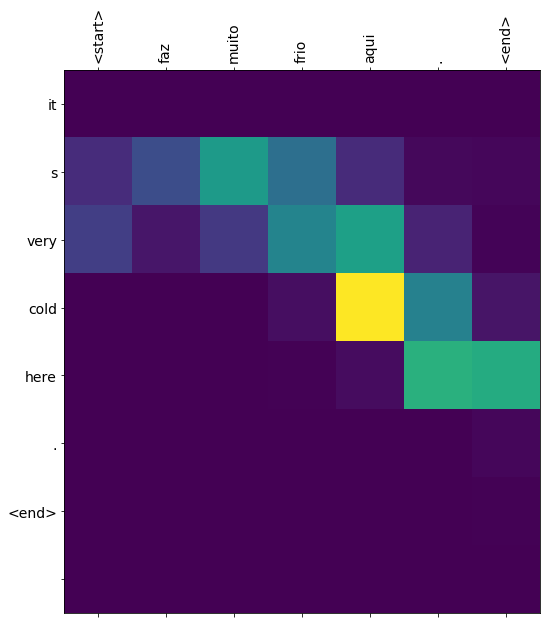

In [44]:
translate('faz muito frio aqui.')

Input: <start> eu gosto daqui . <end>
Predicted translation: i like it here . <end> 


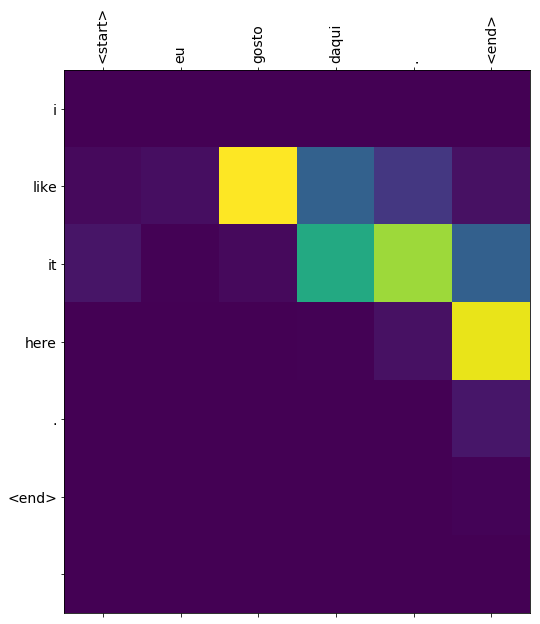

In [45]:
translate('eu gosto daqui.')

Input: <start> eu gosto daqui . <end>
Predicted translation: i like it out of it . <end> 


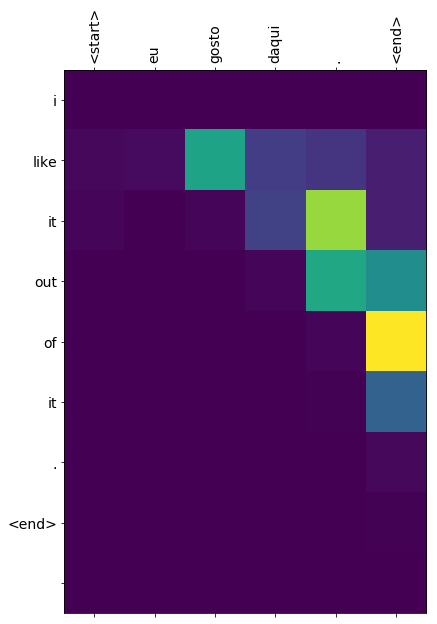

In [42]:
translate('eu gosto daqui.')

In [50]:
translate('linguista.')

KeyError: 'linguista'

Adaptado de: https://www.tensorflow.org/alpha/tutorials/text/nmt_with_attention
https://www.apache.org/licenses/LICENSE-2.0